# Imports

In [148]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

import keras
from keras.models import Model,load_model
from keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv1DTranspose, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization
from keras.optimizers import adam_v2
from keras.losses import MeanSquaredError
from keras.metrics import BinaryCrossentropy

## Test GPU

In [109]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

Good = 24.91 %


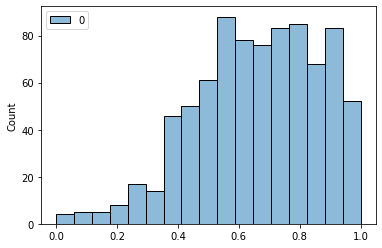

In [150]:
dimension = 2
simmetry = 'p4'
score = 'isotropy'

if os.getcwd().split('\\')[2] == 'lucas':
    score_filename = 'E:/Lucas GAN/Dados/4- Mechanical_scores/RTGA/%sD/%s/%s.csv' %(dimension,simmetry,score)
else:
    score_filename = 'D:/Lucas GAN/Dados/4- Mechanical_scores/RTGA/%sD/%s/%s.csv' %(dimension,simmetry,score)

data = np.loadtxt(score_filename,delimiter=',')
X = data[:,1:-1]
size = int(np.sqrt(X.shape[1]))
X = X.reshape((X.shape[0],size,size,1))

y = data[:,-1]
y = y.reshape((y.shape[0],1))

scaler = MinMaxScaler()
y = scaler.fit_transform(y).round(10)
cutoff = 0.82
sns.histplot(y)
idxs_good = np.where(y>cutoff)[0]
idxs_bad = np.where(y<=cutoff)[0]

y = np.zeros(y.shape)
y[idxs_good] = 1.0
print(f"Good = %.2f %%"%(100*len(idxs_good)/(len(idxs_good)+len(idxs_bad))))
# sns.histplot(y,legend=False);

X_good = X[idxs_good]

input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# Models definition

## Generator

In [151]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,))

    # foundation for 8x8 image
    n_nodes = 128 * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2))(in_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Reshape((size, size, 128))(out_G)
    # upsample to 16x16
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2))(out_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same')(out_G)

    out_density = Lambda(lambda x:x)(out_G)

    model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_density])

    return model
setup_G(input_G,output_G,size).summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_44 (Dense)            (None, 8192)              1056768   
                                                                 
 leaky_re_lu_133 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_22 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_135 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                         

## Discriminator

In [152]:
def style_loss():
    def custom_loss(y_true,y_pred):
        size = y_pred.shape[1]*y_pred.shape[2]
        y_pred = K.round(y_pred)
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)/size
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)/size
        mse = (por_true-por_pred)**2
        return mse
    return custom_loss

def setup_D(input_D,lr,alpha):
    in_D = Input(shape=input_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(in_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Flatten()(out_D)
    out_D = Dense(1, activation='sigmoid')(out_D)

    # compile model
    opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
    
    in_density = Input(shape=input_D)
    out_density = Lambda(lambda x: x)(in_density)

    optimizer = adam_v2.Adam(learning_rate=lr, beta_1=0.5)
    model = Model(
                name='Discriminator', \
                inputs=[in_D,in_density], \
                outputs=[out_D,out_density])

    model.compile(
                loss=['binary_crossentropy',style_loss()], \
                loss_weights=[1.0,alpha], \
                optimizer=optimizer, \
                metrics=['accuracy'])
    return model

setup_D(input_D,1e-4,0.03).summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d_67 (Conv2D)             (None, 8, 8, 64)     640         ['input_68[0][0]']               
                                                                                                  
 dropout_44 (Dropout)           (None, 8, 8, 64)     0           ['conv2d_67[0][0]']              
                                                                                                  
 conv2d_68 (Conv2D)             (None, 4, 4, 64)     36928       ['dropout_44[0][0]']             
                                                                                      

## Setup GAN

In [153]:
def setup_GAN(G_model,D_model,alpha,lr,size):
    optimizer = adam_v2.Adam(learning_rate=lr, beta_1=0.5)
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    model.compile(
                loss=['binary_crossentropy',style_loss()], \
                loss_weights=[1.0,alpha], \
                optimizer=optimizer, \
                metrics=['accuracy']
                )
    return model

alpha = 0.03
lr = 1e-4
setup_GAN(setup_G(input_G,output_G,size),setup_D(input_D,lr,alpha),alpha,lr,size).summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 Generator (Functional)         [(None, 16, 16, 1),  1327233     ['input_70[0][0]']               
                                 (None, 16, 16, 1)]                                               
                                                                                                  
 Discriminator (Functional)     [(None, 1),          38593       ['Generator[0][0]',              
                                 (None, 16, 16, 1)]               'Generator[0][1]']              
                                                                                                

# Defining auxiliary functions

In [130]:
def generate_fake_samples(G_model, input_G, n_samples):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples)
    # predict outputs
    X,_ = G_model.predict(X_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples):
    # generate points in the latent space
    X_input = np.random.randn(input_G * n_samples)
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(n_samples, input_G)
    return X_input

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def summarize_performance(epoch,porosity,G_model, D_model, data, input_G, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(data, n_samples)
    # evaluate discriminator on real examples
    _,_,_,acc_real,_ = D_model.evaluate(x=[X_real,X_real], y=[y_real,porosity*np.ones(X_real.shape)], verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(G_model, input_G, n_samples)
    # evaluate discriminator on fake examples
    _,_,_,acc_fake,_ = D_model.evaluate(x=[X_fake,X_fake], y=[y_fake,porosity*np.ones(X_fake.shape)], verbose=0)
    # summarize discriminator performance
    return  acc_real,acc_fake

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = np.sum(g)/(size*size)
        if p >= porosity-tol and p <= porosity+tol:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return passed/len(geoms),np.array(geoms_).reshape((passed,size,size,1))

# Training GAN

>Epoch: 10 Porosity match: 0%, fake: 0%
>Epoch: 20 Porosity match: 0%, fake: 0%
>Epoch: 30 Porosity match: 0%, fake: 0%
>Epoch: 40 Porosity match: 0%, fake: 0%
>Epoch: 50 Porosity match: 0%, fake: 100%
>Epoch: 60 Porosity match: 0%, fake: 0%
>Epoch: 70 Porosity match: 0%, fake: 0%
>Epoch: 80 Porosity match: 0%, fake: 5%
>Epoch: 90 Porosity match: 0%, fake: 100%
>Epoch: 100 Porosity match: 0%, fake: 0%
>Epoch: 110 Porosity match: 96%, fake: 82%
>Epoch: 120 Porosity match: 0%, fake: 46%
>Epoch: 130 Porosity match: 0%, fake: 100%
>Epoch: 140 Porosity match: 0%, fake: 97%
>Epoch: 150 Porosity match: 0%, fake: 29%
>Epoch: 160 Porosity match: 61%, fake: 89%
>Epoch: 170 Porosity match: 0%, fake: 100%
>Epoch: 180 Porosity match: 33%, fake: 100%
>Epoch: 190 Porosity match: 0%, fake: 24%
>Epoch: 200 Porosity match: 8%, fake: 55%
>Epoch: 210 Porosity match: 4%, fake: 98%
>Epoch: 220 Porosity match: 22%, fake: 93%
>Epoch: 230 Porosity match: 0%, fake: 27%
>Epoch: 240 Porosity match: 0%, fake: 12%


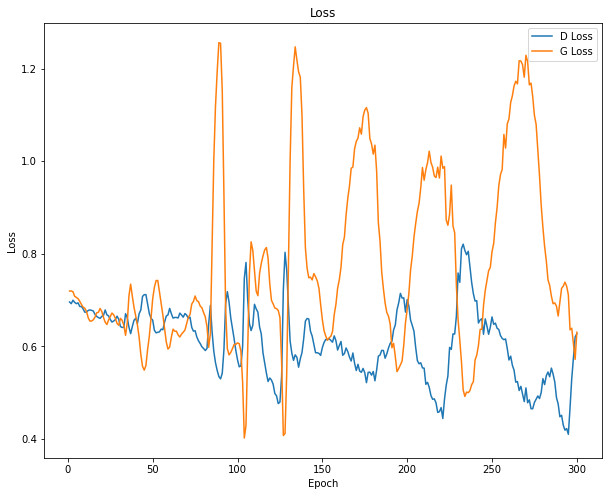

In [154]:
def train(G_model,D_model,GAN_model,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,plot=False,verbose_loss=False,verbose_acc=False):
    
    for file in os.listdir(tmp_models_dir):
        os.remove(tmp_models_dir+file)

    batch_per_epoch = int(X_good.shape[0] /batch_size)
    half_batch = int(batch_size/2)
    
    G_losses = []
    D_losses = []

    for i in range(num_epochs):
        G_losses_epoch = []
        D_losses_epoch = []
        for j in range(batch_per_epoch):
            X_real,y_real = generate_real_samples(X_good,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            if not verbose_loss:
                D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)])
                D_loss = D_loss[0]
            else:
                D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)],return_dict=True)
                print(D_loss)
                D_loss = D_loss['loss']

            D_losses_epoch.append(D_loss)

            X_GAN = generate_input_G(input_G, batch_size)
            y_GAN = np.ones((batch_size, 1))

            if not verbose_loss:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)])
                G_loss = G_loss[0]
            else:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)],return_dict=True)
                print(G_loss)
                G_loss = G_loss['loss']

            if verbose_loss: 
                print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch,  D_loss, G_loss))
            G_losses_epoch.append(G_loss)
        

        G_losses.append(np.array(G_losses_epoch).mean())
        D_losses.append(np.array(D_losses_epoch).mean())
        
        if (i+1) % 10 == 0:
            acc_real,acc_fake = summarize_performance(i+1,porosity,G_model,D_model,X_good,input_G)

            X_test = generate_input_G(input_G,1000)
            geoms, _ = G_model.predict(X_test)
            geoms = np.array(geoms)
            por_match, _ = porosity_match(geoms, porosity, tol_porosity)
            G_model.save(tmp_models_dir+f'epoch_{i+1}_por_{np.round(por_match,2)}_acc_{np.round(acc_fake,2)}.h5')
            
            if verbose_acc:
                print('>Epoch: %i Porosity match: %.0f%%, fake: %.0f%%' % (i+1,por_match*100, acc_fake*100))

    G_losses = np.array(G_losses)
    D_losses = np.array(D_losses)
    if plot:
        fig = plt.figure()
        fig.set_size_inches((10,8)) 
        plt.plot(list(range(1,num_epochs+1)),D_losses,label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),G_losses,label='G Loss')
        plt.legend()
        plt.show()
        
batch_size = 64
num_epochs = 300

alpha = 1e-2 
lr = 1e-4
porosity = 0.5
tol_porosity = 0.02

G = setup_G(input_G,output_G,size)
D = setup_D(input_D,lr,alpha)
GAN = setup_GAN(G,D,alpha,lr,size)

dimension = 2
simmetry = "p4"
prop = "isotropy"
tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/'
train(G,D,GAN,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,plot=True,verbose_loss=False,verbose_acc=True)

## Evaluate `Generator`

## Test porosity

Por_match: 23.26


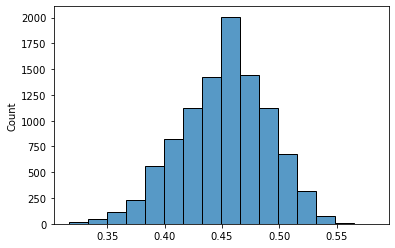

In [155]:
# select models
epoch = 220
models_dir = f"E:/Lucas GAN/Dados/5- GAN_models/{dimension}D/{simmetry}/{prop}/"
G_files = os.listdir(tmp_models_dir)

for i in range(len(G_files)):
    G_file = G_files[i]
    if int(G_file.split('_')[1]) == epoch:
        G = load_model(tmp_models_dir+G_file)
        

test_size = 10000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G.predict(X_test)

porosities =  []
pors = []
porosity = 0.5
tol = 0.02

for generated_geom in generated_geoms:
    p = generated_geom.ravel().round()
    p = p.sum()/p.shape[0]
    if p <= porosity+tol and p >= porosity-tol:
        pors.append(p)
    porosities.append(p)

sns.histplot(porosities,bins=16);
print(f'Por_match: {100*len(pors)/len(porosities)}')

## Visualize geometries

In [156]:
def create_unit(element,size,simmetry):
  if simmetry == 'p4':
    unit_size = 2*size
    # fold_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        
        j_ = [j,2*w-1-i,2*h-1-j,i]
        i_ = [i,j,2*w-1-i,2*h-1-j]
        # (1,7)->(7,14)->(14,8)->(8,1)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el

  return unit

def check_unit(unit,tol):
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  passed = True

  for label in range(1,len(np.unique(labels))):
    label_count = np.where(labels==label)[0].shape[0]
    if label_count > main_label_count:
      main_label = label
      main_label_count = label_count

  if np.where(labels==0)[0].shape[0]+np.where(labels==main_label)[0].shape[0] >(1.0-tol)*unit.shape[0]*unit.shape[0]:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      # check if there is connectivity right-left
      connections_rl = 0
      for i in range(unit.shape[0]):
        if (unit[i,0] == 1 and unit[i,-1] == 1):
          connections_rl += 1

      # check if there is connectivity top-bottom
      connections_tb = 0
      for j in range(unit.shape[1]):
        if (unit[0,j] == 1 and unit[i,-1] == 1):
          connections_tb += 1

      if connections_rl == 0 or connections_tb == 0:
        passed = False
      
    else:
      passed = False
      
  else:
    passed = False
  return passed, unit[:unit.shape[0]//2,:unit.shape[0]//2]

def create_arrange(unit,rows,cols):
  size = unit.shape[0]
  arrange = np.zeros((rows*size,cols*size))
  for i in range(unit.shape[0]):
    for j in range(unit.shape[1]):
      for row in range(rows):
        for col in range(cols):
          arrange[j+row*size,i+col*size] = unit[j,i]
  
  return arrange

porosity=0.5
tol = 0.02
simmetry = 'p4'
_, geometries = porosity_match(generated_geoms,porosity,tol)
size = geometries.shape[1]
geometries_ = []

for i in range(len(geometries)):
  geom = geometries[i].reshape((size,size)).round()
  unit = create_unit(geom,size,simmetry)
  passed,geom_ = check_unit(unit,tol)
  if passed:
    geometries_.append(geom_)

geometries = np.array(geometries_)
# Get scores
top = 10
scores = D.predict([geometries,geometries])[0].ravel()
top_idxs = np.argsort(-scores)[:top]
for top_idx in top_idxs:
  geom = geometries[top_idx]
  unit = create_unit(geom.reshape((size,size)),size,simmetry)
  print("Score: %.2f Porosity: %.2f"%(scores[top_idx],geom.ravel().sum()/(size*size)))
  print('Element')
  plt.imshow(geom,cmap="Greys")
  plt.show()
  print('Unit')
  plt.imshow(unit,cmap="Greys")
  plt.show()
  print('Arranged geometry')
  arrange = create_arrange(unit,3,3)
  plt.imshow(arrange,cmap="Greys")
  plt.show()

# sns.histplot(np.sum(generated_geoms.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size),bins=32);